<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/scooby_doo_wtf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 7.6MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491627 sha256=69abdc0edb623eccd1d10f485cceaf09e563bdc7c7d2af7c7bfd610175792980
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
import warnings
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import lightgbm as lgb
from scipy.stats import pearsonr, spearmanr
from tqdm.notebook import tqdm
import shap
shap.initjs()

In [ ]:
project_dir = 'drive/My Drive/scooby-doo'
df = pd.read_csv(f"{project_dir}/data/Scooby-Doo Completed.csv")
df['date.aired'] = pd.to_datetime(df['date.aired'])
bool_cols = [x for x in df.columns.values if ('caught.' in x) | ('captured.' in x) | ('unmask.' in x) | ('snack.' in x) | ('trap.work.first' in x) | ('non-suspect' in x) | ('arrested' in x) | ('door.gag' in x) | ('batman' in x) | ('scooby-dum' in x) | ('scrappy-doo' in x) | ('hex.girls' in x) | ('blue.falcon' in x)]
df.loc[:, bool_cols] = df.loc[:, bool_cols].astype(bool).astype(int)
df = df.drop('index', axis=1)
counting_cols = ['monster.amount', 'suspects.amount',
       'culprit.amount', 'split.up', 'another.mystery', 'set.a.trap',
       'jeepers', 'jinkies', 'my.glasses', 'zoinks', 'groovy',
       'scooby.doo.where.are.you', 'rooby.rooby.roo']
for col in counting_cols:
  df[f'{col}_per_min'] = df[col].div(df['run.time'])
df.shape

(603, 87)

In [ ]:
target = 'imdb'
feats = df.dtypes[df.dtypes==int].index.values.tolist() + df.dtypes[df.dtypes==float].index.values.tolist()
feats = [x for x in feats if (target not in x) & ('engagement' not in x) & ('run.time' not in x) & (x not in counting_cols)]


In [ ]:
warnings.filterwarnings('ignore')
df_pred = pd.DataFrame()
kf = KFold(20, shuffle=True)
model_data = df.dropna(subset=feats+[target])
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  model = LinearRegression()
  model.fit(train_data.loc[:, feats], train_data[target])
  test_data[f"{target}_linear"] = pd.Series(model.predict(test_data.loc[:, feats]), index=test_data.index)
  df_pred = df_pred.append(test_data)
warnings.filterwarnings('default')
df_pred.shape


(367, 88)

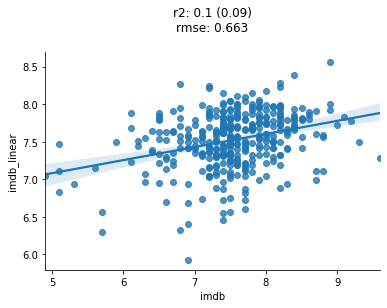

In [ ]:
rmse = mean_squared_error(df_pred[target], df_pred[f"{target}_linear"])**0.5
r2 = pearsonr(df_pred[target], df_pred[f"{target}_linear"])[0]**2
r2np = spearmanr(df_pred[target], df_pred[f"{target}_linear"])[0]**2

sns.regplot(data=df_pred, x=target, y=f"{target}_linear")
plt.title(f"r2: {round(r2, 2)} ({round(r2np,2)})\nrmse: {round(rmse, 3)}\n")
sns.despine()
plt.show()

In [ ]:
warnings.filterwarnings('ignore')
df_pred = pd.DataFrame()
kf = KFold(20, shuffle=True)
model_data = df.dropna(subset=feats+[target])
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]
  model = RandomForestRegressor()
  model.fit(train_data.loc[:, feats], train_data[target])
  test_data[f"{target}_rf"] = pd.Series(model.predict(test_data.loc[:, feats]), index=test_data.index)
  df_pred = df_pred.append(test_data)
warnings.filterwarnings('default')
df_pred[f"{target}_over_expected"] = df_pred[target].sub(df_pred[f"{target}_rf"])
df_pred.shape


(367, 89)

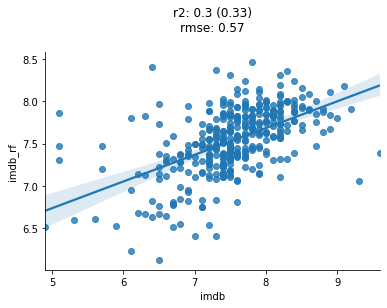

In [ ]:
model_type = 'rf'
rmse = mean_squared_error(df_pred[target], df_pred[f"{target}_{model_type}"])**0.5
r2 = pearsonr(df_pred[target], df_pred[f"{target}_{model_type}"])[0]**2
r2np = spearmanr(df_pred[target], df_pred[f"{target}_{model_type}"])[0]**2

sns.regplot(data=df_pred, x=target, y=f"{target}_{model_type}")
plt.title(f"r2: {round(r2, 2)} ({round(r2np,2)})\nrmse: {round(rmse, 3)}\n")
sns.despine()
plt.show()

In [ ]:
model = RandomForestRegressor()
model.fit(model_data.loc[:, feats], model_data[target])
explainer = shap.TreeExplainer(model, model_data.loc[:, feats])
shap_values = explainer.shap_values(model_data.loc[:, feats])

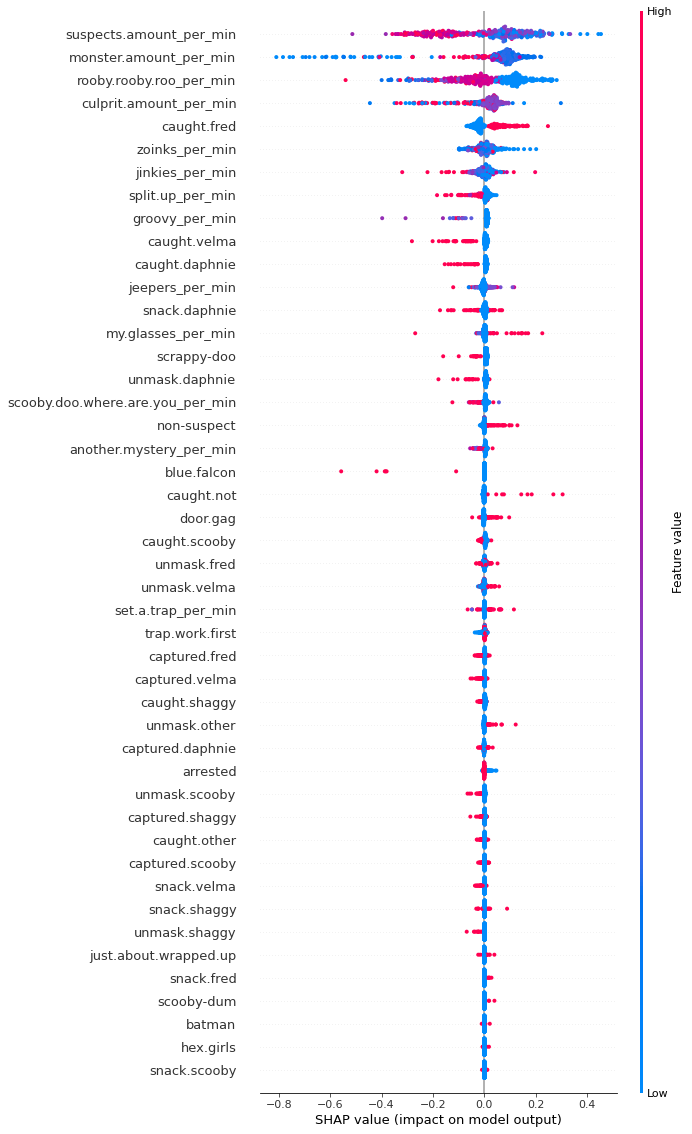

In [ ]:
shap.summary_plot(shap_values, model_data.loc[:, feats], max_display=100)

In [ ]:
per_min_cols = [x for x in df_pred.columns.values if 'per_min' in x]
df_pred['month_agg'] = df_pred['date.aired'].dt.year.astype(str).add(df_pred['date.aired'].dt.month.astype(str))
df_plt =df_pred.loc[:, ['month_agg']+per_min_cols].groupby('month_agg', as_index=False).mean()

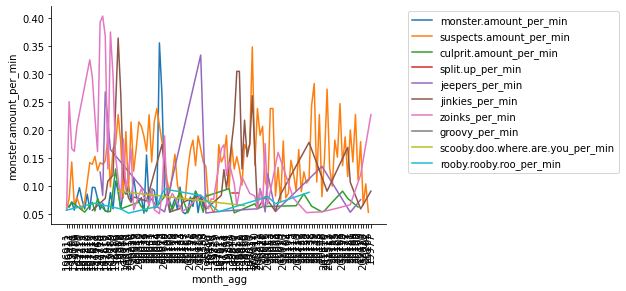

In [ ]:
x = 'month_agg'
for y in per_min_cols:
  sns.lineplot(data=df_plt.loc[df_plt[y]>0.05,[x, y]], x=x, y=y, label=y)

sns.despine()
plt.legend(bbox_to_anchor=(1.05,1), loc=2)
plt.xticks(rotation=90)
plt.show()

Synopsis
Scooby, Shaggy, Freddy, Daphne and Velma are boating to a spooky mansion on an island. Scooby has been chosen as an heir to the late Colonel Beauregard Sanders, whom Scooby saved from drowning in a fishpond years before. It is a creepy night and there is thunder and lightning.

One of the Colonel's lawyers, Cosgood Creeps, comes to greet them and ushers them into the mansion where they meet the other four heirs: Cousin Slicker, Cousin Simple, Nephew Norble, and "Sweet" Cousin Maldahyde. Cosgood informs the heirs that his partner, Cuthbert Crawls, was unable to attend and the only instructions from the Colonel were to play a record on an old phonograph. The recording tells the heirs that they must stay the night to get the fortune and that the mansion is haunted, much to Scooby and Shaggy's horror. Should any heir leave the island before morning, they forfeit their share of the inheritance and it will be split among the remaining heirs at the mansion. The whole gang decide they'll stay with Scooby.

Fred, Shaggy, and Scooby are getting ready for the night, with the former two in the bedroom taking turns reading a book while Scooby decides to take a bath. Fred tells Scooby to hurry up, and he is scrubbing up when a ghost appears from a tile trapdoor. The bathtub slides through a secret passage and down a chute into a coal cellar with Scooby in it. While he is sitting on a pile of coal, a green, chain-rattling phantom appears, laughing. Scooby is terrified and he breaks out of the basement. He frantically tries to explain what happened to Fred and Shaggy, but after seeing the bathtub in place and bolted to the floor, they dismiss it and go to bed.

The clock chimes midnight and a green ghost goes into Cousin Simple's room and stands over his bed, laughing. The gang wakes up and finds Cousin Simple is gone. On a dusty mirror, a menacing message warns them to leave the island, signed by the Phantom Shadow.

The gang decide to rig up a dummy of Scooby-Doo to catch the ghost when he comes to grab the dummy. Scooby and Shaggy are watching from outside on the drainpipe, when suddenly the ghost pushes the drainpipe loose. Velma tries to help them, but gets pulled out of the window, too.

The drainpipe swings the three down into a cave that turns out to be a secret passage underneath the house. They find the Phantom Shadow's footprints and decide to follow them. The footprints lead to a room with a collection of Civil War memorabilia. They find a wagon full of uniforms, and one starts flying and chases them. As it corners them in an elevator and Scooby starts growling and making faces at it, the uniform fell to the ground as a duck inside of it flies away scared.

Shaggy and Scooby go up in the elevator, which takes them to a secret entrance in Cousin Slicker's room. Inside, they discover that Cousin Slicker is missing as well. The gang all meet up and realize that all of the other heirs are now missing, leaving Scooby as the only remaining heir on the island.

The gang follow the sound of an organ playing. They find the organ and then see something written down on a music book. It reads "Feed the organ, and watch the floor". Scooby begins playing the organ, but the doors lock and the walls begin to close in! Scooby starts playing as fast as he can to try and undo whatever activated the trap, eventually succeeding in making the walls stop. Velma deduces that Feed refers to the musical notes F-E-E-D. Playing the notes, a trapdoor opens and the gang climb down steps to the catacombs. There they find the other heirs inside coffins, and one more coffin that is empty and dog shaped.

Two Green Ghosts appear and Scooby faints as the gang runs away. The gang try to carry the now unconscious Scooby, but he hits the top of the doorway and falls down. Scooby is confused as the two Phantoms stand in front of him laughing. Shaggy then gives him a Scooby Snack which wakes him up. They continue running and finally hide in a chandelier, but one of the Phantoms cuts it loose and it falls to the floor. Separated, Scooby and Shaggy find a wine rack and use the corks as ammunition against the Phantoms. They then run into a closet and emerge wearing dress clothes, set up a record player, and start dancing with the Phantoms. Leading them into the organ room, Shaggy opens the trapdoor and they send the Phantoms falling into the basement.

After the gang meets up, Velma notices that Shaggy has gotten green paint on his hands. That gives Fred an idea. They devise a trap, including a fan, soap suds, a spring-loaded ironing board, and a washing machine. It backfires when Scooby turns on the fan not only too soon, but also the wrong way, sending the entire contraption airborne; however, it still manages to catch the Phantoms. The gang unmask the ghosts as the lawyers Cosgood Creeps and Cuthbert Crawls. They painted themselves to be green ghosts as part of a ploy to scare all of the heirs off of the island so they could keep the million dollar fortune for themselves. As they successfully scared the heirs away, they added realistically painted dummies into the coffins to make them look like victims. As the only heir still on the mansion grounds, Scooby inherits the million dollars, only to learn it's all worthless Confederate money. Then a floating bone materializes, but that's one thing that Scooby isn't afraid of.

In [ ]:
shap.initjs()
episode_id = 34
shap.force_plot(explainer.expected_value, shap_values[episode_id], model_data.loc[:, feats].values[0], feature_names=feats)

In [ ]:
df_pred.columns.values

array(['series.name', 'network', 'season', 'title', 'imdb', 'engagement',
       'date.aired', 'run.time', 'format', 'monster.name',
       'monster.gender', 'monster.type', 'monster.subtype',
       'monster.species', 'monster.real', 'monster.amount', 'caught.fred',
       'caught.daphnie', 'caught.velma', 'caught.shaggy', 'caught.scooby',
       'captured.fred', 'captured.daphnie', 'captured.velma',
       'captured.shaggy', 'captured.scooby', 'unmask.fred',
       'unmask.daphnie', 'unmask.velma', 'unmask.shaggy', 'unmask.scooby',
       'snack.fred', 'snack.daphnie', 'snack.velma', 'snack.shaggy',
       'snack.scooby', 'unmask.other', 'caught.other', 'caught.not',
       'trap.work.first', 'setting.terrain', 'setting.country/state',
       'suspects.amount', 'non-suspect', 'arrested', 'culprit.name',
       'culprit.gender', 'culprit.amount', 'motive', 'if.it.wasnt.for',
       'and.that', 'door.gag', 'number.of.snacks', 'split.up',
       'another.mystery', 'set.a.trap', 'jeepers

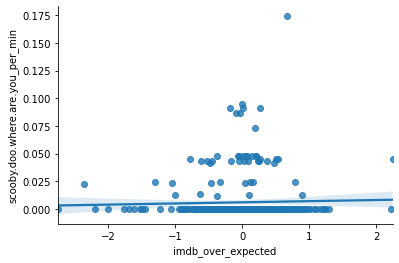

In [ ]:
sns.regplot(data=df_pred, x='imdb_over_expected', y='scooby.doo.where.are.you_per_min')
sns.despine()
plt.show()

In [ ]:
df_pred.tail()

,series.name,network,season,title,imdb,engagement,date.aired,run.time,format,monster.name,monster.gender,monster.type,monster.subtype,monster.species,monster.real,monster.amount,caught.fred,caught.daphnie,caught.velma,caught.shaggy,caught.scooby,captured.fred,captured.daphnie,captured.velma,captured.shaggy,captured.scooby,unmask.fred,unmask.daphnie,unmask.velma,unmask.shaggy,unmask.scooby,snack.fred,snack.daphnie,snack.velma,snack.shaggy,snack.scooby,unmask.other,caught.other,caught.not,trap.work.first,...,and.that,door.gag,number.of.snacks,split.up,another.mystery,set.a.trap,jeepers,jinkies,my.glasses,just.about.wrapped.up,zoinks,groovy,scooby.doo.where.are.you,rooby.rooby.roo,batman,scooby-dum,scrappy-doo,hex.girls,blue.falcon,fred.va,daphnie.va,velma.va,shaggy.va,scooby.va,monster.amount_per_min,suspects.amount_per_min,culprit.amount_per_min,split.up_per_min,another.mystery_per_min,set.a.trap_per_min,jeepers_per_min,jinkies_per_min,my.glasses_per_min,zoinks_per_min,groovy_per_min,scooby.doo.where.are.you_per_min,rooby.rooby.roo_per_min,imdb_rf,imdb_over_expected,month_agg
438,Scooby-Doo Mystery Incorporated,Cartoon Network,1,Mystery Solvers Club State Finals,8.2,254.0,2011-05-03,22,TV Series,Lord Infernicus,Male,Undead,Skeleton,Human,False,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,...,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,Frank Welker,Grey DeLisle,Mindy Cohn,Matthew Lillard,Frank Welker,0.045455,0.272727,0.045455,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,7.825,0.375,20115
482,Scooby-Doo Mystery Incorporated,Cartoon Network,2,Come Undone,9.3,260.0,2013-04-05,22,TV Series,"Evil Entity,Minions","Male,Male","Mythical,Ancient","Evil,Humanoid","Element,Human",True,2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,NaN,0,0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,0,0,0,0,0,Frank Welker,Grey DeLisle,Mindy Cohn,Matthew Lillard,Frank Welker,0.090909,0.000000,0.000000,0.0,0.0,0.0,0.045455,0.090909,0.0,0.090909,0.0,0.045455,0.045455,7.058,2.242,20134
504,"Be Cool, Scooby-Doo!",Cartoon Network,1,Area 51 Adjacent,7.4,71.0,2015-10-23,22,TV Series,Alien,Male,Extraterrestrial,Alien,Alien,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0,0,0,0,0,Frank Welker,Grey DeLisle,Kate Micucci,Matthew Lillard,Frank Welker,0.045455,0.090909,0.045455,0.0,0.0,0.0,0.000000,0.000000,0.0,0.090909,0.0,0.000000,0.000000,7.984,-0.584,201510
536,"Be Cool, Scooby-Doo!",Boomerang,2,Silver Scream,7.4,38.0,2017-11-22,22,TV Series,Ghost of Archie Barnes,Male,Ghost,Ghost,Human,False,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,NaN,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,Frank Welker,Grey DeLisle,Kate Micucci,Matthew Lillard,Frank Welker,0.045455,0.227273,0.045455,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,8.030,-0.630,201711
567,Scooby-Doo and Guess Who?,Boomerang,1,Attack of the Weird Al-Osaurus!,7.5,61.0,2019-08-29,23,TV Series,"Dinosaur,Dinosaur","Male,Male","Animal,Animal","Allosaurus,Ceratosarus","Dinosaur,Dinosaur",False,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,musical styles of Weird Al Yanovic,0,0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0,0,0,0,0,Frank Welker,Grey DeLisle,Kate Micucci,Matthew Lillard,Frank Welker,0.086957,0.173913,0.086957,0.0,0.0,0.0,0.086957,0.043478,0.0,0.130435,0.0,0.000000,0.000000,7.565,-0.065,20198


In [ ]:
df_pred.loc[df_pred['date.aired']<='1980-01-01', ['series.name', 'network', 'season', 'title', 'engagement',
       'run.time','date.aired','imdb','imdb_rf', 'imdb_over_expected']].sort_values('imdb_over_expected', ascending=False).tail(20)

,series.name,network,season,title,engagement,run.time,date.aired,imdb,imdb_rf,imdb_over_expected
46,The New Scooby-Doo Movies,CBS,2,The Weird Winds of Winona,91.0,44,1973-10-13,7.3,7.578000,-0.278000
53,The Scooby-Doo Show,ABC,1,The Gruesome Game of the Gator Ghoul,95.0,24,1976-09-25,7.5,7.818000,-0.318000
38,The New Scooby-Doo Movies,CBS,1,The Phantom of the Country Music Hall,81.0,41,1972-12-09,7.6,7.928000,-0.328000
135,The Scooby-Doo Show,ABC,3,Scooby's Chinese Fortune Kooky Caper,85.0,23,1978-11-25,7.5,7.832000,-0.332000
150,Scooby-Doo and Scrappy-Doo (first series),ABC,1,When You Wish Upon a Star Creature,48.0,21,1979-12-01,7.2,7.555000,-0.355000
139,The Scooby-Doo Show,ABC,3,The Beast is Awake in Bottomless Lake,84.0,23,1978-12-23,7.1,7.481000,-0.381000
4,"Scooby Doo, Where Are You!",CBS,1,Decoy for a Dognapper,391.0,21,1969-10-11,7.5,7.885000,-0.385000
89,The Scooby-Doo Show,ABC,2,The Creepy Heap from the Deep,71.0,24,1977-10-29,7.4,7.785000,-0.385000
138,The Scooby-Doo Show,ABC,3,The Warlock of Wimbledon,84.0,23,1978-12-16,6.8,7.211000,-0.411000
41,The New Scooby-Doo Movies,CBS,2,The Mystery of Haunted Island,103.0,44,1973-09-08,7.4,7.849000,-0.449000


The gang travel to the North Pole to visit their friend, Professor Kreuger. When they arrive, they ski down to the Eskimo village where Professor Kreuger lives. At the village, the gang find almost all of the igloos smashed into pieces and Professor Kreuger missing. They split up to look for clues, where Scooby discovers a huge paw print in the snow. Chief Manook, chief of the village, arrives and informs them that a snow beast captured the professor. According to legends, the beast (who measures about fifty feet tall) arrived after the village was built on sacred lands. The gang heads to Professor Kreuger's hut, where they meet his assistant, Jean Baptiste. He leaves in a hurry before the snow beast returns. The only clue found in the hut was a drawing of three totem poles, discovered by Velma.

The snow beast then arrives and chases the gang, before capturing Chief Manook. Using a dog sled, the gang follows the beast and found the three huge totem poles. It is there they discover more clues: black snow, and a thumping sound coming from inside the totem poles. The beast arrives again, and chases the gang some more. After they escape, they follow his tracks into a nearby ice cave. They find two tunnels and split up and look for more clues. At the end of their tunnel, Fred, Velma, and Daphne discover a huge submarine, and more of the strange black snow. Shaggy and Scooby are less fortunate, and are only chased by the beast. Fred, Velma, and Daphne follow a flight of stairs and find Professor Kreuger and Chief Manook locked up.

Realizing what is going on, the gang devise a trap to capture the beast. Scooby lures him into a patch of ice, where the snow beast slips, and crashes into a totem pole, where he falls apart as well as the totem pole itself. It turns out, the beast was actually a huge robot, programmed by Baptiste. The totem poles were actually oil derricks, which explained the black snow. He used the submarine to smuggle the oil out of the country.

In [ ]:
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
model_data.loc[:, feats+[target]]

,caught.fred,caught.daphnie,caught.velma,caught.shaggy,caught.scooby,captured.fred,captured.daphnie,captured.velma,captured.shaggy,captured.scooby,unmask.fred,unmask.daphnie,unmask.velma,unmask.shaggy,unmask.scooby,snack.fred,snack.daphnie,snack.velma,snack.shaggy,snack.scooby,unmask.other,caught.other,caught.not,trap.work.first,non-suspect,arrested,door.gag,batman,scooby-dum,scrappy-doo,hex.girls,blue.falcon,just.about.wrapped.up,monster.amount_per_min,suspects.amount_per_min,culprit.amount_per_min,split.up_per_min,another.mystery_per_min,set.a.trap_per_min,jeepers_per_min,jinkies_per_min,my.glasses_per_min,zoinks_per_min,groovy_per_min,scooby.doo.where.are.you_per_min,rooby.rooby.roo_per_min,imdb
0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0.0,0.047619,0.095238,0.047619,0.047619,0.047619,0.000000,0.000000,0.000000,0.047619,0.047619,0.000000,0.000000,0.047619,8.1
1,0,0,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0.045455,0.090909,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136364,0.000000,0.045455,0.000000,8.1
2,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0.047619,0.000000,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.095238,0.000000,0.000000,8.0
3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0.0,0.047619,0.095238,0.047619,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.095238,0.047619,0.000000,0.000000,7.8
4,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0.0,0.047619,0.047619,0.047619,0.000000,0.047619,0.000000,0.000000,0.000000,0.047619,0.000000,0.000000,0.047619,0.000000,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0.0,0.045455,0.136364,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,8.4
584,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0.0,0.043478,0.173913,0.043478,0.000000,0.043478,0.000000,0.000000,0.043478,0.000000,0.000000,0.043478,0.000000,0.043478,7.6
585,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0.0,0.045455,0.181818,0.090909,0.000000,0.000000,0.045455,0.045455,0.000000,0.000000,0.136364,0.000000,0.000000,0.000000,8.2
599,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,0,0,0,0,0,0.0,0.026316,0.065789,0.026316,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.013158,0.000000,0.000000,0.000000,6.3


In [ ]:
df_pred

,series.name,network,season,title,imdb,engagement,date.aired,run.time,format,monster.name,monster.gender,monster.type,monster.subtype,monster.species,monster.real,monster.amount,caught.fred,caught.daphnie,caught.velma,caught.shaggy,caught.scooby,captured.fred,captured.daphnie,captured.velma,captured.shaggy,captured.scooby,unmask.fred,unmask.daphnie,unmask.velma,unmask.shaggy,unmask.scooby,snack.fred,snack.daphnie,snack.velma,snack.shaggy,snack.scooby,unmask.other,caught.other,caught.not,trap.work.first,...,and.that,door.gag,number.of.snacks,split.up,another.mystery,set.a.trap,jeepers,jinkies,my.glasses,just.about.wrapped.up,zoinks,groovy,scooby.doo.where.are.you,rooby.rooby.roo,batman,scooby-dum,scrappy-doo,hex.girls,blue.falcon,fred.va,daphnie.va,velma.va,shaggy.va,scooby.va,monster.amount_per_min,suspects.amount_per_min,culprit.amount_per_min,split.up_per_min,another.mystery_per_min,set.a.trap_per_min,jeepers_per_min,jinkies_per_min,my.glasses_per_min,zoinks_per_min,groovy_per_min,scooby.doo.where.are.you_per_min,rooby.rooby.roo_per_min,imdb_rf,imdb_over_expected,month_agg
7,"Scooby Doo, Where Are You!",CBS,1,Foul Play in Funland,8.2,358.0,1969-11-01,21,TV Series,Charlie the Robot,Male,Mechanical,Humanoid,Robot,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,0,0,0,0,Frank Welker,Stefanianna Christopherson,Nicole Jaffe,Casey Kasem,Don Messick,0.047619,0.095238,0.047619,0.000000,0.0,0.047619,0.000000,0.000000,0.047619,0.000000,0.0,0.047619,0.047619,7.992,0.208,196911
28,The New Scooby-Doo Movies,CBS,1,The Frickert Fracas,7.9,116.0,1972-09-30,43,TV Series,Scarecrow,Male,Possessed Object,Scarecrow,Human,False,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,NaN,1,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,9.0,0.0,0.0,0.0,0,0,0,0,0,Frank Welker,Heather North,Nicole Jaffe,Casey Kasem,Don Messick,0.023256,0.093023,0.023256,0.000000,0.0,0.000000,0.023256,0.023256,0.000000,0.209302,0.0,0.000000,0.000000,7.146,0.754,19729
129,The Scooby-Doo Show,ABC,3,"Jeepers, It's the Jaguaro!",7.2,91.0,1978-10-28,22,TV Series,Jaguaro,Male,Animal,Beast,Jungle-Monster,False,1,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,NaN,0,0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,8.0,0.0,0.0,1.0,0,0,0,0,0,Frank Welker,Heather North,Pat Stevens,Casey Kasem,Don Messick,0.045455,0.181818,0.090909,0.000000,0.0,0.000000,0.318182,0.090909,0.000000,0.363636,0.0,0.000000,0.045455,7.213,-0.013,197810
146,Scooby-Doo and Scrappy-Doo (first series),ABC,1,The Demon of the Dugout,7.5,51.0,1979-11-03,21,TV Series,Dragon Beast,Male,Mythical,Humanoid,Dragon,False,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,NaN,0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0,0,1,0,0,Frank Welker,Heather North,Pat Stevens,Casey Kasem,Don Messick,0.047619,0.142857,0.047619,0.047619,0.0,0.000000,0.047619,0.000000,0.000000,0.142857,0.0,0.000000,0.047619,7.650,-0.150,197911
153,Scooby-Doo and Scrappy-Doo (first series),ABC,1,Rocky Mountain Yiiiii!,7.5,48.0,1979-12-15,21,TV Series,Ghost of Jeremiah Pratt,Male,Ghost,Phantom,Human,False,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,NaN,0,0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,8.0,0.0,0.0,1.0,0,0,1,0,0,Frank Welker,Heather North,Marla Scott,Casey Kasem,Don Messick,0.047619,0.142857,0.047619,0.000000,0.0,0.000000,0.000000,0.238095,0.000000,0.380952,0.0,0.000000,0.047619,7.492,0.008,197912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,Scooby-Doo Mystery Incorporated,Cartoon Network,1,Mystery Solvers Club State Finals,8.2,254.0,2011-05-03,22,TV Series,Lord Infernicus,Male,Undead,Skeleton,Human,False,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,...,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,Fr

In [ ]:
warnings.filterwarnings('ignore')
df_pred = pd.DataFrame()
folds = 20
kf = KFold(folds, shuffle=True)
model_data = df.dropna(subset=feats+[target])
for train_idx, test_idx in tqdm(kf.split(model_data), total=folds):
  train_data = model_data.iloc[train_idx]
  test_data = model_data.iloc[test_idx]

  lgb_train = lgb.Dataset(train_data.loc[:, feats], train_data[target])
  lgb_test = lgb.Dataset(test_data.loc[:, feats], test_data[target])
  p = {
      'objective':'regression',
      'num_iterations':10000,
      'learning_rate':0.01
  }
  model = lgb.train(p, lgb_train, valid_sets=lgb_test, verbose_eval=False)
  test_data[f"{target}_gbm"] = pd.Series(model.predict(test_data.loc[:, feats]), index=test_data.index)
  df_pred = df_pred.append(test_data)
warnings.filterwarnings('default')
df_pred.shape


(367, 88)

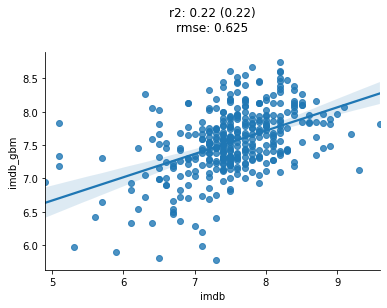

In [ ]:
model_type = 'gbm'
rmse = mean_squared_error(df_pred[target], df_pred[f"{target}_{model_type}"])**0.5
r2 = pearsonr(df_pred[target], df_pred[f"{target}_{model_type}"])[0]**2
r2np = spearmanr(df_pred[target], df_pred[f"{target}_{model_type}"])[0]**2

sns.regplot(data=df_pred, x=target, y=f"{target}_{model_type}")
plt.title(f"r2: {round(r2, 2)} ({round(r2np,2)})\nrmse: {round(rmse, 3)}\n")
sns.despine()
plt.show()

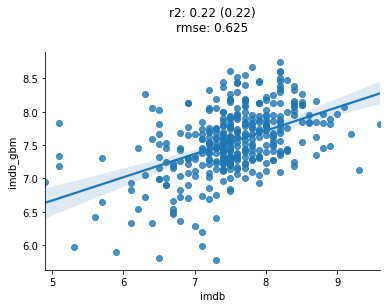

In [ ]:
model_type = 'gbm'
rmse = mean_squared_error(df_pred[target], df_pred[f"{target}_{model_type}"])**0.5
r2 = pearsonr(df_pred[target], df_pred[f"{target}_{model_type}"])[0]**2
r2np = spearmanr(df_pred[target], df_pred[f"{target}_{model_type}"])[0]**2

sns.regplot(data=df_pred, x=target, y=f"{target}_{model_type}")
plt.title(f"r2: {round(r2, 2)} ({round(r2np,2)})\nrmse: {round(rmse, 3)}\n")
sns.despine()
plt.show()

# the effect of jinkies

In [ ]:
df.columns.values

array(['series.name', 'network', 'season', 'title', 'imdb', 'engagement',
       'date.aired', 'run.time', 'format', 'monster.name',
       'monster.gender', 'monster.type', 'monster.subtype',
       'monster.species', 'monster.real', 'monster.amount', 'caught.fred',
       'caught.daphnie', 'caught.velma', 'caught.shaggy', 'caught.scooby',
       'captured.fred', 'captured.daphnie', 'captured.velma',
       'captured.shaggy', 'captured.scooby', 'unmask.fred',
       'unmask.daphnie', 'unmask.velma', 'unmask.shaggy', 'unmask.scooby',
       'snack.fred', 'snack.daphnie', 'snack.velma', 'snack.shaggy',
       'snack.scooby', 'unmask.other', 'caught.other', 'caught.not',
       'trap.work.first', 'setting.terrain', 'setting.country/state',
       'suspects.amount', 'non-suspect', 'arrested', 'culprit.name',
       'culprit.gender', 'culprit.amount', 'motive', 'if.it.wasnt.for',
       'and.that', 'door.gag', 'number.of.snacks', 'split.up',
       'another.mystery', 'set.a.trap', 'jeepers


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


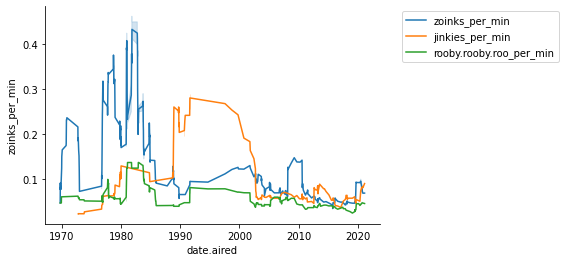

In [ ]:
for col in ['zoinks_per_min','jinkies_per_min', 'rooby.rooby.roo_per_min']:
  df_plt = df.loc[df[col]>0]
  df_plt[col] = df_plt[col].rolling(10, min_periods=1).mean()
  sns.lineplot(data=df_plt, x='date.aired', y=col, label=col)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [ ]:
target = 'jinkies_per_min'
feats = ['monster.amount_per_min', 'suspects.amount_per_min',
       'culprit.amount_per_min', 'split.up_per_min',
       'another.mystery_per_min', 'set.a.trap_per_min', 'jeepers_per_min',
       'jinkies_per_min', 'my.glasses_per_min', 'zoinks_per_min',
       'groovy_per_min', 'scooby.doo.where.are.you_per_min',
       'rooby.rooby.roo_per_min']